# Data Gathering for Indoor Localization

This notebook contains the process of loading a text file containing indoor localization data into a dataframe. [Will convert this into a .yp file later]

### Problem Description

> **Task**: Search for a Survey paper and list some approaches present in the literature 
https://arxiv.org/pdf/1709.01015
In this paper, the following localization techniques are listed:
* Angle of Arrival(AoA): Detects angle of signal using multiple antennas
* Time of Flight(ToF): Measures time a signal takes to arrive using signal propagation speed
* Return Time of Flight(RToF): ToF, but also consideres time it takes back to sender after reaching receiver. uses a reply mechanism
* Received Signal Strength(RSS): Uses strenght of signal to estimate distance using known signal maps (fingerprinting)

based on:
* Wifi
* Radio Frequency Identification Device(RFID)
* Ultra Wideband
* Bluetooth

> **Task**: Formulate the Problem Description, Challanges and Ml formulation

**Problem Description**: The goal of this project to create a indoor localization estimator based on KNN using Wifi Signal Strength data derived from [this dataset of the universitiy of mannheim](https://ieee-dataport.org/open-access/crawdad-mannheimcompass-v-2006-09-13). In this dataset, the system estimates the position of mobile devices using RSS values collected from nearby access points. The task of the indoor localization estimator is to estimate the X, Y coordinates of a device as well as the degree.

**Challenges**:
* Accuracy is may vary due to various factors like noise or user orientation/degree
* High Dimensionality of the data may make it hard to interpret the scans
* Uneven data distribution, as the amount of points collected per access point may vary
* Environemt in which data is collected may vary over long time, which can also affect the accuracy

**ML Formulation**:

KNN for estimating the position of a scanned device. For training, the offline data is used and for testing, the online data is used.

Input: RSSI of access points, frequency?

Output: position in coordinates -> estimation of where device is.

### Reading the data

In [11]:
# Includes
from datetime import datetime
import re
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

First, let's take a look at first few lines of the data to get an overview.

In [2]:
offline_file = "data/offline.final.trace.txt"

count = 0
with open(offline_file, 'r') as file:
    for line in file:
        print(line.strip())
        count += 1
        if count == 120:
            break

# timestamp=2006-02-11 08:31:58
# usec=250
# minReadings=110
t=1139643118358;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:97:8a=-38,2437000000,3;00:14:bf:b1:97:90=-56,2427000000,3;00:0f:a3:39:e1:c0=-53,2462000000,3;00:14:bf:b1:97:8d=-65,2442000000,3;00:14:bf:b1:97:81=-65,2422000000,3;00:14:bf:3b:c7:c6=-66,2432000000,3;00:0f:a3:39:dd:cd=-75,2412000000,3;00:0f:a3:39:e0:4b=-78,2462000000,3;00:0f:a3:39:e2:10=-87,2437000000,3;02:64:fb:68:52:e6=-88,2447000000,1;02:00:42:55:31:00=-84,2457000000,1
t=1139643118744;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:97:8a=-38,2437000000,3;00:0f:a3:39:e1:c0=-54,2462000000,3;00:14:bf:b1:97:90=-56,2427000000,3;00:14:bf:3b:c7:c6=-67,2432000000,3;00:14:bf:b1:97:81=-66,2422000000,3;00:14:bf:b1:97:8d=-70,2442000000,3;00:0f:a3:39:e0:4b=-79,2462000000,3;00:0f:a3:39:dd:cd=-73,2412000000,3;00:0f:a3:39:e2:10=-83,2437000000,3;02:00:42:55:31:00=-85,2457000000,1
t=1139643119002;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:

It can be seen, that there is a summary of the timestamp using comments with '#', usec and min amount of readings during that time. These values can be derived from the actual data anyway, therefore they are just skipped. It can be seen that after every 110 datapoints, a comment is present, which indicates that the data is consistent, at least from the first look.


> *Task*: Consider the two following obvious choices of how to store the data in a structured way and give at least a pro and a con for each:
>1. transfer each row in input file to a row in data frame
>2. store one signal per row. That implies that each line in the input file turns into multiple rows in the data frame.

1. transfer each row in input file to a row in data frame
* Pro: Easier to implement
* Con: Hard to query data from each row, as the calculation of the values needs to be repeated every time.

2. store one signal per row. That implies that each line in the input file turns into multiple rows in the data frame.
* Pro: Cleaner to read and query data as every line contains a single value
* Cons: More complex to read data from file

Now each line of the actual data contains the following features:

* t = unix Timestamp (int)

* id = MAC of scanning device (string)

* pos = Position of the scanning device (tuple containing three values, should be split into seperate columns)

* degree = Rotational orientation of the device. from 0° to 360° obviously (float)

* Readings: for each read datapoint repeat:
  * MAC = MAC address of the scanned device (string)
  * RSSI = Signal strength of the scanned device in dBm(int)
  * frequency = Signal frequency of the scanned device in Hz (integer)
  * mode = type of device that sent signal [access point = 3, device in adhoc mode = 1] (intger)

For each line, the different features can easily be extracted using regular expressions. The following code snippet contains the different expressions used for each feature:

In [2]:
regex_t = "t=[0-9]+;" # matches t=<number>;
regex_id = "id=([0-9A-Fa-f]{2}(:[0-9A-Fa-f]{2}){5});" # matches only valid mac addresses
regex_pos = "pos=\d+\.\d+,\d+\.\d+,\d+\.\d+;" # matches x,y,z position, no negative values right now, will add if needed
regex_degree = "degree=(?:360(?:\.0+)?|(?:[0-9]|[1-9][0-9]|1[0-9]{2}|2[0-9]{2}|3[0-5][0-9])(?:\.\d+)?);" # matches degrees from 0 to 360, including precision
regex_readings = "([0-9A-Fa-f]{2}(:[0-9A-Fa-f]{2}){5})=-?\d+(?:\.\d+)?,-?\d+,\d" # matches a single distinct reading, works for the list of all readings in a line.

Now two functions need to be implemented: one for processing a line and one for processing the whole file using the function for processing the line. 
Keep in mind that when matching the regular expression, no additional checks need to be done to ensure that split lines contain the correct amount of values. also, datatypes are not defined here, this will be done when creating the dataframe

In [3]:
def process_line(line: str):
    """
    Processes a line of the localization dataset

    Parameters:
    line (string): A line containing localization measurement data

    Returns:
    A dictionary containing all values with converted datatype.
    """
    line_data = {}

    # t
    match = re.search(regex_t, line)
    if match:
        value = match.group(0).split('=')[1].strip(';')
        line_data["t"] = int(value)

    # id
    match = re.search(regex_id, line)
    if match:
        value = match.group(0).split('=')[1].strip(';')
        line_data["id"] = value

    # pos
    match = re.search(regex_pos, line)
    if match:
        value = match.group(0).split('=')[1].strip(';').split(',') # coordinates are split again by "," seperator
        line_data["pos_x"] = float(value[0])
        line_data["pos_y"] = float(value[1])
        line_data["pos_z"] = float(value[2])

    # degree
    match = re.search(regex_degree, line)
    if match:
        value = match.group(0).split('=')[1].strip(';')
        line_data["degree"] = float(value)

    # readings
    matches = re.finditer(regex_readings, line)
    line_data["readings"] = []
    for match in matches:
        reading = {}
        values = match.group(0).split(',') # this does not split MAC and RSSI, they are seperated by "="
        mac_rssi = values[0].split('=')
        reading["mac"] = mac_rssi[0]
        reading["rssi"] = int(mac_rssi[1])
        reading["frequency"] = int(values[1])
        reading["mode"] = int(values[2])

        line_data["readings"].append(reading)
    return line_data

Due to the fact that the orientation values are not always multiples of 45°, they need to be rounded. in order to do this properly, a functon needs to be implemented:

In [4]:
def round_orientation(angle):
    """
    Rounds an orientation angle to a multiple of 45°

    Parameters:
    line (string): any angle

    Returns:
    rounded orientation as multiple of 45°
    """
    angle = angle % 360 # modulo 360 caps value between 0 and 360
    rounded = round(angle / 45) * 45
    return rounded % 360 # another modulo to round values near 360 to 0

In [5]:
def read_data(file_name: str, submacs: list):
    """
    Reads and converts a localization data file into a dataframe

    Parameters:
    file_name (string): A file containing localization measurement data

    Returns:
    A dataframe containing the processed and cleaned localization data
    """
    rows = []
    with open(file_name, 'r') as file:
        lines = [line for line in file if not line.startswith("#")] # skips comments
        print("Measurement Amount", len(lines)) # print amount of measurements to compare with dataset description
        for line in lines:     
            line_dict = process_line(line.strip())
            
            reading_rows = []
            for reading in line_dict['readings']:
                row = {
                    't': line_dict['t'],
                    'id': line_dict['id'],
                    'pos_x': line_dict['pos_x'],
                    'pos_y': line_dict['pos_y'],
                    'pos_z': line_dict['pos_z'],
                    'degree': line_dict['degree'],
                    'mac': reading['mac'],
                    'rssi': reading['rssi'],
                    'frequency': reading['frequency'],
                    'mode': reading['mode']
                }
                reading_rows.append(row)
            rows.extend(reading_rows)
    
    df = pd.DataFrame(rows)
    # convert datatypes
    df = df.astype({ # convert datatypes
        't': 'int64',
        'id': 'string',
        'pos_x': 'float64',
        'pos_y': 'float64',
        'pos_z': 'float64',
        'degree': 'float64',
        'rssi': 'int32',
        'frequency': 'int64',
        'mode': 'int8'
    })

    # add angle column with rounded degrees
    df['angle'] = df['degree'].apply(round_orientation)
    # skip rows with mode != 3 (no adhc mode)
    df = df[df['mode'] == 3]
    # remove mode = type  column
    df = df.drop('mode', axis=1)
    # Format time
    df['time'] = pd.to_datetime(df['t'], unit='ms') # unix timestamp has ms format
    df = df.rename(columns={'t': 'raw_time'})
    # remove z coordinate
    df = df.drop('pos_z', axis=1)
    # drop frequency 
    df = df.drop('frequency', axis=1)
    # remove id = scanMAC
    df = df.drop('id', axis=1) # there was only one mac address, this column is not needed
    # filter dataframe to contain only values with specified mac addresses
    df = df[df['mac'].isin(submacs)]
    # create posXY locatio identifier like = 0.0-0.0
    df['posXY'] = df["pos_x"].astype(str) + "-" + df["pos_y"].astype(str)

    df = df.drop_duplicates() # there are a few thousand duplicate rows in the data, therefore they are remove
    return df

In [6]:
offline_file = "data/offline.final.trace.txt"
submacs = ["00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a", "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d", "00:14:bf:b1:97:81"]

df_offline = read_data(offline_file, submacs)
df_offline

Measurement Amount 146080


,raw_time,pos_x,pos_y,degree,mac,rssi,angle,time,posXY
0,1139643118358,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,0,2006-02-11 07:31:58.358,0.0-0.0
1,1139643118358,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,0,2006-02-11 07:31:58.358,0.0-0.0
2,1139643118358,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,0,2006-02-11 07:31:58.358,0.0-0.0
3,1139643118358,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,0,2006-02-11 07:31:58.358,0.0-0.0
4,1139643118358,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,0,2006-02-11 07:31:58.358,0.0-0.0
...,...,...,...,...,...,...,...,...,...
1181622,1141936870456,20.0,8.0,315.7,00:14:bf:b1:97:8d,-61,315,2006-03-09 20:41:10.456,20.0-8.0
1181623,1141936870456,20.0,8.0,315.7,00:14:bf:b1:97:8a,-60,315,2006-03-09 20:41:10.456,20.0-8.0
1181624,1141936870456,20.0,8.0,315.7,00:14:bf:b1:97:81,-60,315,2006-03-09 20:41:10.456,20.0-8.0
1181625,1141936870456,20.0,8.0,315.7,00:14:bf:b1:97:90,-68,315,2006-03-09 20:41:10.456,20.0-8.0


In [7]:
df_pkl = pd.read_pickle('data/df.pkl')
df_pkl
# notes for comparison: i have more values overall and frequency column is not part of the .pkl file so i also removed it

,time,posX,posY,orientation,mac,signal,angle,rawTime,posXY
0,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,0,1139643118358,0.0-0.0
1,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,0,1139643118358,0.0-0.0
2,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,0,1139643118358,0.0-0.0
3,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,0,1139643118358,0.0-0.0
4,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,0,1139643118358,0.0-0.0
...,...,...,...,...,...,...,...,...,...
1181622,2006-03-09 20:41:10.456,20.0,8.0,315.7,00:14:bf:b1:97:8d,-61,315,1141936870456,20.0-8.0
1181623,2006-03-09 20:41:10.456,20.0,8.0,315.7,00:14:bf:b1:97:8a,-60,315,1141936870456,20.0-8.0
1181624,2006-03-09 20:41:10.456,20.0,8.0,315.7,00:14:bf:b1:97:81,-60,315,1141936870456,20.0-8.0
1181625,2006-03-09 20:41:10.456,20.0,8.0,315.7,00:14:bf:b1:97:90,-68,315,1141936870456,20.0-8.0


In [59]:
print("Check if they are equal: " , df_pkl.equals(df_offline))

Check if they are equal:  False


## Explorative Data Analysis

After the data was successfully loaded and transformed into a dataframe, the next step is to perform explorative data analysis on the dataframe.

### Univariate Data Analysis

In [ ]:
df_offline.rssi.describe() # describing signal strength

# Signal strength is measured in dBm (Dezibel Milliwatt), with negative values that get lower when moving away from sender

count    904985.000000
mean        -59.916372
std          10.385336
min         -98.000000
25%         -67.000000
50%         -59.000000
75%         -53.000000
max         -25.000000
Name: rssi, dtype: float64

### Straification of signal strength statistics

In [ ]:
df_offline.groupby([ "mac"]).rssi.agg(["median", "mean", "min", "max", "std", "count"])

,median,mean,min,max,std,count
mac,,,,,,
00:0f:a3:39:dd:cd,-71.0,-70.454794,-98,-46,8.124709,145358
00:0f:a3:39:e1:c0,-54.0,-53.701635,-92,-34,5.794879,145818
00:14:bf:3b:c7:c6,-62.0,-60.676822,-90,-38,7.080960,124535
00:14:bf:b1:97:81,-56.0,-56.347957,-87,-29,8.023517,119279
00:14:bf:b1:97:8a,-58.0,-56.644002,-90,-26,9.561987,128759
00:14:bf:b1:97:8d,-54.0,-53.764789,-93,-25,8.302156,119765
00:14:bf:b1:97:90,-69.0,-67.024261,-93,-34,10.639894,121471


It can be observed that median and mean are mostly around 60, min value is mostly around 90, max value is mostly around 30 with 00:0f:a3:39:dd:cd being an outlier, and std of around 8-9. For every mac address, there are at leat arund 120000 measurements.

Next, let's aggregate the statistics by xy position:

In [12]:
df_offline.groupby(["posXY", "mac"]).rssi.agg(["median", "mean", "min", "max", "std", "count"])

median       mean  min  max       std  count
posXY   mac                                                            
0.0-0.0 00:0f:a3:39:dd:cd   -70.0 -69.792517  -90  -61  3.789440    882
        00:0f:a3:39:e1:c0   -53.0 -53.469989  -89  -47  4.587269    883
        00:14:bf:3b:c7:c6   -66.0 -66.241335  -86  -55  3.445990    779
        00:14:bf:b1:97:81   -63.0 -64.477952  -81  -55  4.648838    703
        00:14:bf:b1:97:8a   -38.0 -38.823684  -53  -30  5.273841    760
...                           ...        ...  ...  ...       ...    ...
9.0-8.0 00:14:bf:3b:c7:c6   -53.0 -52.953083  -74  -46  3.141700    746
        00:14:bf:b1:97:81   -59.0 -59.261474  -73  -53  3.466682    719
        00:14:bf:b1:97:8a   -59.0 -58.836129  -82  -49  4.086309    775
        00:14:bf:b1:97:8d   -53.0 -53.295518  -75  -44  4.828713    714
        00:14:bf:b1:97:90   -67.0 -67.247945  -78  -58  3.624358    730

[1162 rows x 6 columns]

In summary, it can be observed that depending on the sender, signal strenght may vary. This is to be exepcted, because the different access points are positioned in different locations with different orientations. Additionally, various factors may affect the received signal strength.

### Visual EDA

First, lets visualize and interpret the effects of orienatation on the received signal strength. The goal here is to answer the following questions:

- Is the variation in RSS consistent across all MACs?
- Does the impact of orientation diminish with distance?

In [150]:
def orientation_SS_box_plot(data, x, y):
    """
    Creates boxplots for the signal strenght per orientation

    Parameters:
    data (Dataframe): Dataframe containing the rssi data
    x (int): X coordinate for measurements
    y (int): Y coordinate for measurements

    Returns:
    type: Boxplots for every mac address for the specified x and y coordinates.
    """
    coordinates = f"{x:.1f}-{y:.1f}" # create coordinate string
    data_x_y = data[data["posXY"] == coordinates] # filter data for given coordinate
    macs = data_x_y['mac'].unique() # get unique mac values to calculate amount of plots

    n = len(macs) # amount of plots
    cols = 3 # fixed amount of columns
    rows = -(-n // cols) # amount of rows

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 7 * rows)) # create subplots wiht appropriate figure dimensions
    axes = axes.flatten()

    for i, mac in enumerate(macs):
        subset = data_x_y[data_x_y['mac'] == mac].copy()
        sns.boxplot(data=subset, x='angle', y='rssi', ax=axes[i], showfliers=True) # showfliers shows outliers
        axes[i].set_title(f'MAC: {mac}', fontsize=10)
        axes[i].set_ylabel('RSSI (dBm)')
        axes[i].set_xlabel('Angle (°)')
        axes[i].set_ylim(-90, -30)
        axes[i].tick_params(axis='x', rotation=45) 

        axes[i].set_facecolor('#e6edfa') # set background color
        axes[i].grid(True, axis='y', color='white', linestyle='--', linewidth=0.6, alpha=0.8)
        for spine in axes[i].spines.values():
            spine.set_visible(False)


    # Hide unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("RSSI Boxplot per angle", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


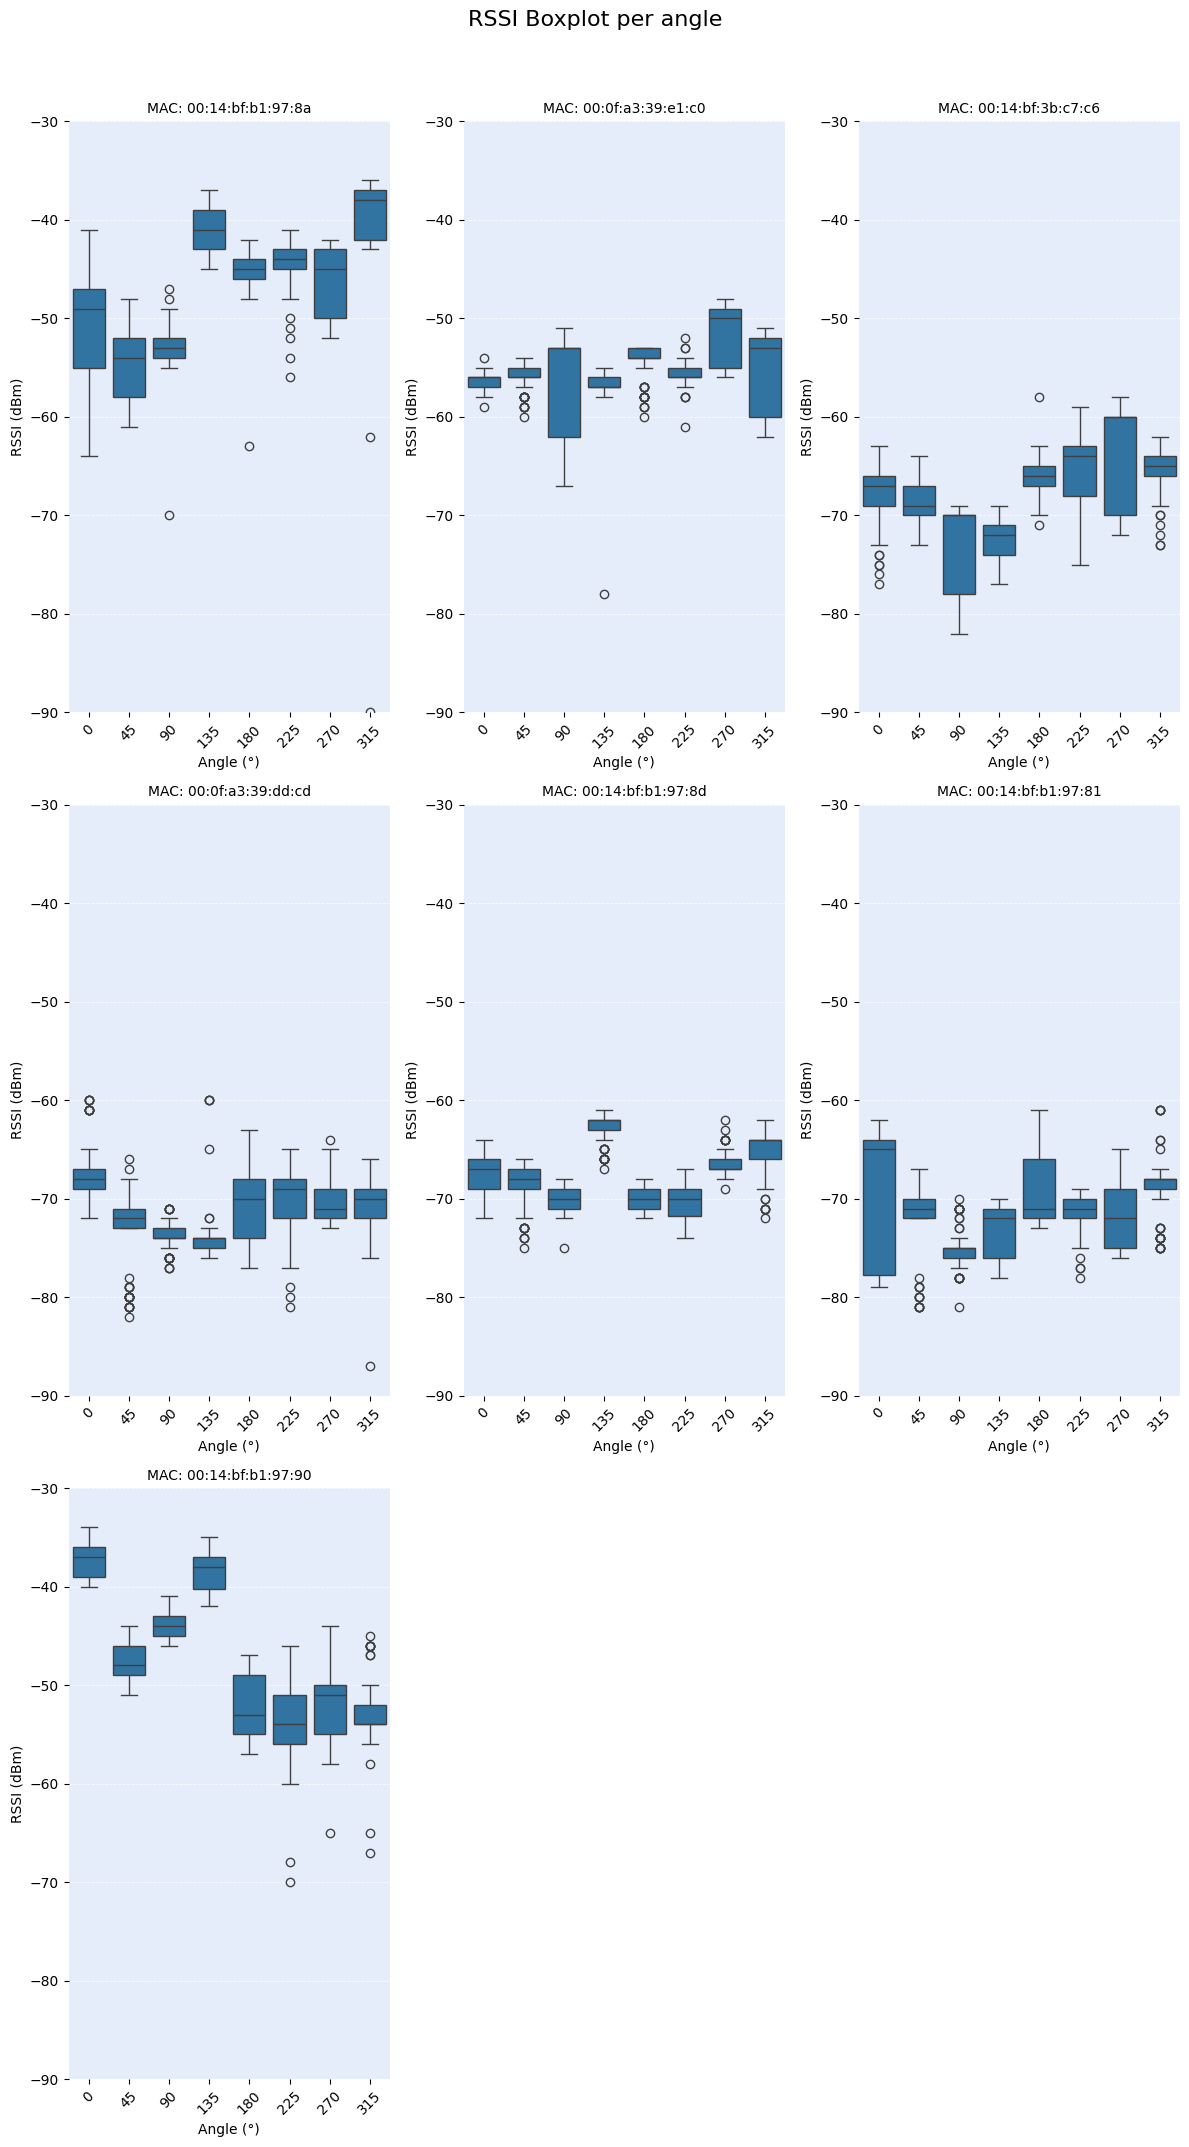

In [151]:
orientation_SS_box_plot(df_offline, 2, 12) # plot signal strength per orientation for every access point.

> Is the variation in RSS consistent across all MACs?

**Answer**: No, variation is different depending on the mac address

Now to answer the second question, a kernel density plot can be used:

In [155]:
def density_plot(data, x, y):
    """
    Creates kernel density plots for the signal strenght per orientation

    Parameters:
    data (Dataframe): Dataframe containing the rssi data
    x (int): X coordinate for measurements
    y (int): Y coordinate for measurements

    Returns:
    type: Kernel density plot for every mac address for the specified x and y coordinates.
    """
    coordinates = f"{x:.1f}-{y:.1f}" # create coordinate string
    data_x_y = data[data["posXY"] == coordinates] # filter data for given coordinate
    macs = data_x_y['mac'].unique() # get unique mac values to calculate amount of plots
    angles = data_x_y['angle'].unique()

    cols = len(macs) # fixed amount of columns
    rows = len(angles) # amount of rows
    n = cols * rows # amount of plots

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 2 * rows)) # create subplots wiht appropriate figure dimensions
    axes = axes.flatten()

    for row_id, angle in enumerate(angles):
        for col_id, mac in enumerate(macs):
            i = col_id + row_id * cols
            subset = data_x_y[data_x_y['mac'] == mac].copy()
            subset = subset[subset['angle'] == angle].copy()
            sns.kdeplot(data=subset, x='rssi', ax=axes[i], common_norm=False, fill=True)
            axes[i].set_ylabel('Density')
            axes[i].set_xlabel('Signal Strenght ')
            axes[i].set_ylim(0, 1)
            axes[i].set_xlim(-90, -10)

            axes[i].set_facecolor('#e6edfa') # set background color
            axes[i].grid(True, axis='y', color='white', linestyle='--', linewidth=0.6, alpha=0.8)

            # show y axis only for first column
            if col_id != 0:
                axes[i].set_ylabel('')
                axes[i].tick_params(axis='y', left=False, labelleft=False)

            # show mac address name only in first row
            if row_id == 0:
                axes[i].set_title(f'MAC: {mac}', fontsize=10)

            # Show x-axis label only for the bottom row
            if row_id != rows - 1:
                axes[i].set_xlabel('')
                axes[i].tick_params(axis='x', bottom=False, labelbottom=False)

            # show angle on the right most side for every row
            if col_id == cols - 1:
                axes[i].text(1.05, 0.5, f"angle = {angle}°", va='center', ha='left', fontsize=11, rotation=270, transform=axes[i].transAxes)

            # remove borders
            for spine in axes[i].spines.values():
                spine.set_visible(False)

    # Hide unused axes
    total_plots = rows * cols
    for j in range(len(macs) * len(angles), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("RSSI Kernel Density plot per MAC and angle", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

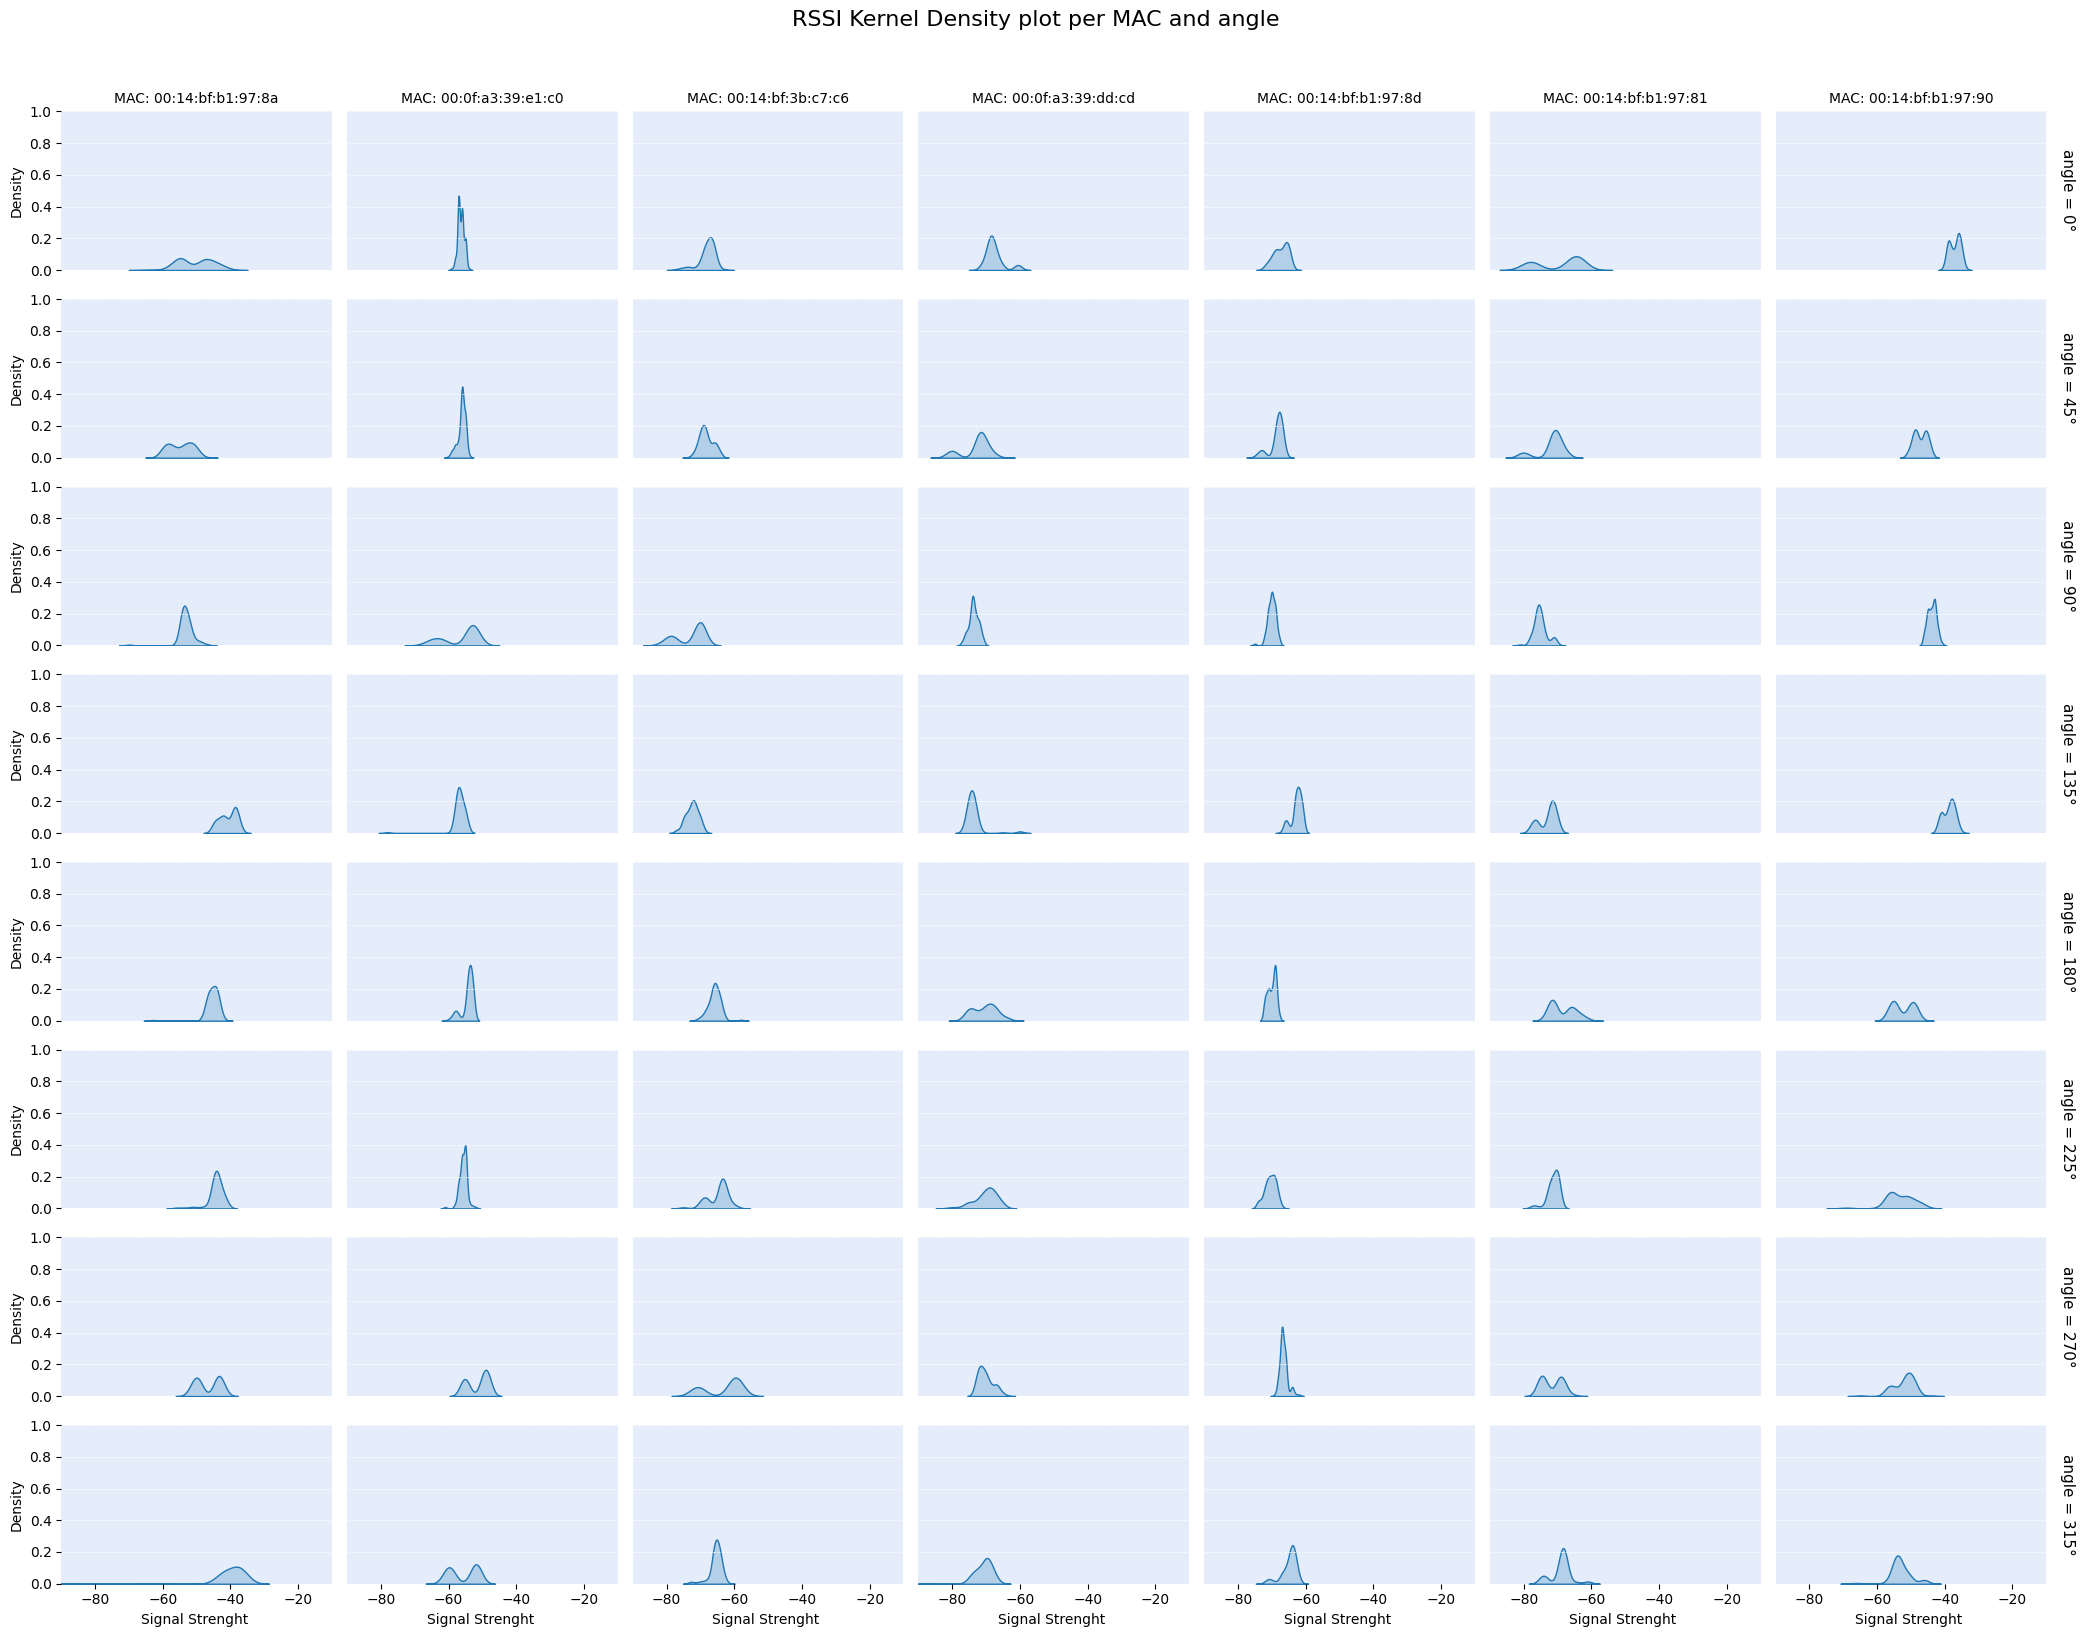

In [156]:
density_plot(df_offline, 2, 12)

> Does the impact of orientation diminish with distance?

**Answer**: Yes, this can be seen that some access points have high varience between angles, which can be interpretet as them being close to the receiver of the signals. Other access points with less variety between angles are farther away from the receiver.

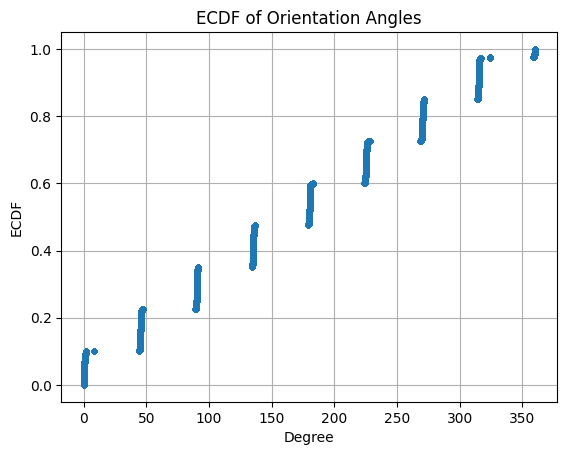

In [ ]:
# Plot ECDF
degrees = df_offline["degree"].to_numpy()
x = np.sort(degrees)
y = np.arange(1, len(degrees) + 1) / len(degrees)

plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Degree')
plt.ylabel('ECDF')
plt.title("ECDF of Orientation Angles")
plt.grid(True)
plt.show()

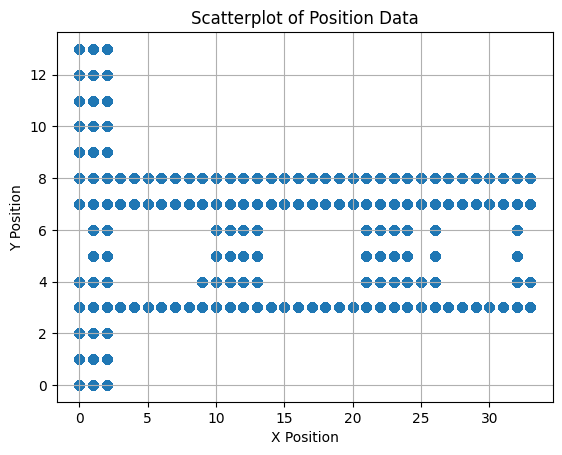

In [275]:
# Scatterplot of Position data
plt.scatter(df_offline["pos_x"], df_offline["pos_y"])
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Scatterplot of Position Data")
plt.grid(True)
plt.show()

### Loading the online data

In [257]:
online_file = "data/online.final.trace.txt"
submacs = ["00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a", "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d", "00:14:bf:b1:97:81"]

df_online = read_data(online_file, submacs)
df_online

Measurement Amount 6592


,raw_time,pos_x,pos_y,degree,mac,rssi,angle,time,posXY
0,1139692477303,0.00,0.05,130.5,00:14:bf:b1:97:8a,-43,135,2006-02-11 21:14:37.303,0.0-0.05
1,1139692477303,0.00,0.05,130.5,00:0f:a3:39:e1:c0,-52,135,2006-02-11 21:14:37.303,0.0-0.05
2,1139692477303,0.00,0.05,130.5,00:14:bf:3b:c7:c6,-62,135,2006-02-11 21:14:37.303,0.0-0.05
3,1139692477303,0.00,0.05,130.5,00:14:bf:b1:97:81,-58,135,2006-02-11 21:14:37.303,0.0-0.05
4,1139692477303,0.00,0.05,130.5,00:14:bf:b1:97:8d,-62,135,2006-02-11 21:14:37.303,0.0-0.05
...,...,...,...,...,...,...,...,...,...
53297,1141928791755,21.45,6.62,27.3,00:14:bf:b1:97:8d,-43,45,2006-03-09 18:26:31.755,21.45-6.62
53298,1141928791755,21.45,6.62,27.3,00:0f:a3:39:e1:c0,-56,45,2006-03-09 18:26:31.755,21.45-6.62
53299,1141928791755,21.45,6.62,27.3,00:14:bf:b1:97:8a,-59,45,2006-03-09 18:26:31.755,21.45-6.62
53300,1141928791755,21.45,6.62,27.3,00:14:bf:3b:c7:c6,-59,45,2006-03-09 18:26:31.755,21.45-6.62
